In [1]:
!pip install transformers datasets scikit-learn tqdm matplotlib seaborn --quiet
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Running on {device}")


✅ Running on cpu


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from transformers import AutoTokenizer, RobertaForSequenceClassification
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from tqdm import tqdm


C:\Users\AS\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
model_path = 'outputs_roberta/fine_tuned_roberta_mrpc'  # Adjust if needed
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path)
model.to(device)
model.eval()


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [5]:
dataset = load_dataset('glue', 'mrpc')

def tokenize_function(example):
    return tokenizer(example['sentence1'], example['sentence2'], truncation=True, padding='max_length', max_length=128)

encoded_dataset = dataset.map(tokenize_function, batched=True)
encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

val_dataset = encoded_dataset['validation']
test_dataset = encoded_dataset['test']


In [6]:
@torch.no_grad()
def predict_logits(model, dataloader):
    model.eval()
    all_logits = []
    all_labels = []
    for batch in tqdm(dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        all_logits.append(logits.cpu())
        all_labels.append(labels.cpu())
    return torch.cat(all_logits), torch.cat(all_labels)

def compute_nonconformity(logits, true_labels):
    true_logits = logits.gather(1, true_labels.unsqueeze(1)).squeeze(1)
    nonconformity_scores = -true_logits
    return nonconformity_scores


In [7]:
# 6. Apply 3-Fold Cross Conformal Prediction (XCP)
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

all_calib_scores = []

val_indices = np.arange(len(val_dataset))
for train_idx, calib_idx in kfold.split(val_indices):
    calib_subset = Subset(val_dataset, calib_idx)
    calib_loader = DataLoader(calib_subset, batch_size=32)

    calib_logits, calib_labels = predict_logits(model, calib_loader)
    calib_scores = compute_nonconformity(calib_logits, calib_labels)

    all_calib_scores.append(calib_scores)

# Stack calibration scores from all folds
all_calib_scores = torch.cat(all_calib_scores)


100%|████████████████████████████████████████████| 5/5 [00:22<00:00,  4.44s/it]


In [8]:
# 7. Predict and Apply XCP on Test Set
test_loader = DataLoader(test_dataset, batch_size=32)
test_logits, test_labels = predict_logits(model, test_loader)

def xcp_predict(test_logits, calib_scores, epsilon=0.1):
    prediction_sets = []
    for logit_vec in test_logits:
        p_values = []
        for class_idx in range(2):
            nonconf_score = -logit_vec[class_idx]
            p_val = (torch.sum(calib_scores <= nonconf_score).item() + 1) / (len(calib_scores) + 1)
            p_values.append(p_val)
        prediction = [i for i, p in enumerate(p_values) if p > epsilon]
        prediction_sets.append(prediction)
    return prediction_sets

prediction_sets = xcp_predict(test_logits, all_calib_scores, epsilon=0.1)


100%|██████████████████████████████████████████| 54/54 [04:38<00:00,  5.15s/it]


In [9]:
# 8. Evaluate XCP Results
# Forced prediction
forced_preds = test_logits.argmax(dim=1)

# Metrics
macro_f1 = f1_score(test_labels.numpy(), forced_preds.numpy(), average='macro')
print(f"📈 Forced Prediction Macro F1: {macro_f1:.4f}")

# Average prediction set size
avg_set_size = np.mean([len(p) for p in prediction_sets])
print(f"📦 Average Prediction Set Size: {avg_set_size:.2f}")


📈 Forced Prediction Macro F1: 0.8476
📦 Average Prediction Set Size: 1.91


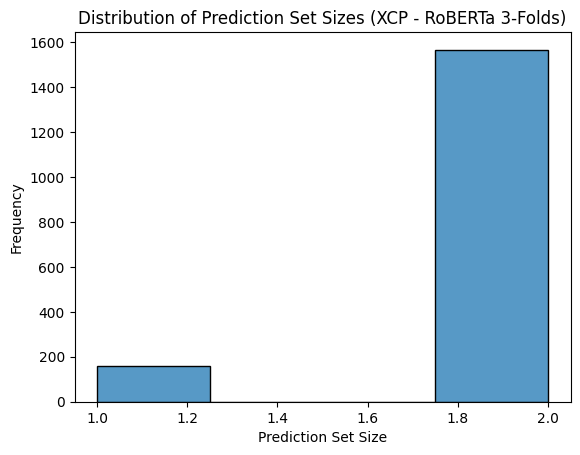

In [10]:
# 9. Plot Distribution of Prediction Set Sizes
sns.histplot([len(p) for p in prediction_sets], bins=4)
plt.title("Distribution of Prediction Set Sizes (XCP - RoBERTa 3-Folds)")
plt.xlabel("Prediction Set Size")
plt.ylabel("Frequency")
plt.show()
